## fft

In [3]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.misc
import cv2
import imreg_dft as ird

source_path = '/Users/yizuotian/pyspace/OpenCV-Python-Tutorial/001-图像配准/images/template.jpg'
target_path = '/Users/yizuotian/pyspace/OpenCV-Python-Tutorial/001-图像配准/images/IMG_20210419_085432.jpg'
target_path = '/Volumes/Elements/土方智能工厂/棋盘格/010.JPG'
src_img = cv2.imread(source_path)
tgt_img=cv2.imread(target_path)
im1 = sp.misc.imread(target_path, True)
im0 = sp.misc.imread(source_path, True)

/Users/yizuotian/miniconda2/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/Users/yizuotian/miniconda2/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


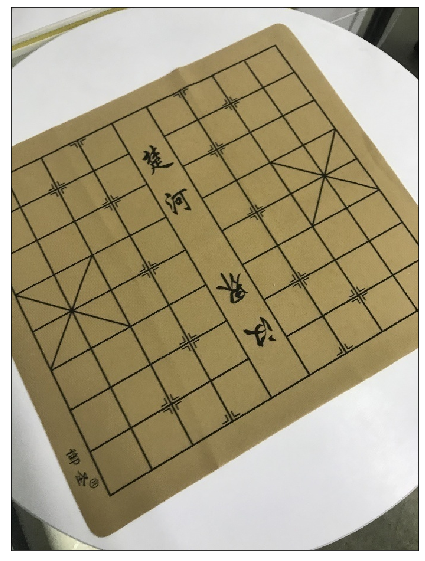

In [176]:
plt.figure(figsize=(10,10))
ax=plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(tgt_img[...,::-1])

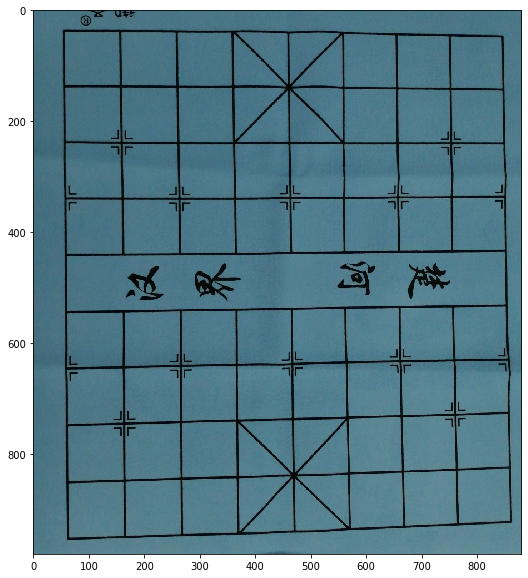

In [177]:
plt.figure(figsize=(10,10))

plt.imshow(src_img)

In [178]:
h,w = im0.shape
im1 = cv2.resize(im1,(w,h))

result = ird.similarity(im0, im1, numiter=3)

In [179]:
result.keys(),result

(dict_keys(['tvec', 'success', 'angle', 'scale', 'Dscale', 'Dangle', 'Dt', 'timg']),
 {'tvec': array([-149.0674263 , -318.18425337]),
  'success': 0.013575756023524293,
  'angle': 154.9840414453006,
  'scale': 1.2391711713906433,
  'Dscale': 0.0019946681536353607,
  'Dangle': 0.04591836734693878,
  'Dt': 0.25,
  'timg': array([[127.75671 , 127.467255, 127.9377  , ..., 152.89609 , 152.7576  ,
          151.2928  ],
         [125.95461 , 126.08149 , 126.39227 , ..., 152.28876 , 151.98242 ,
          149.81622 ],
         [125.2761  , 124.39614 , 124.99172 , ..., 151.745   , 151.3537  ,
          149.04187 ],
         ...,
         [155.4201  , 155.46394 , 155.47865 , ..., 154.95215 , 155.1755  ,
          155.33006 ],
         [154.34038 , 154.23439 , 154.17317 , ..., 154.23326 , 154.41232 ,
          154.44408 ],
         [152.0676  , 151.3998  , 151.31097 , ..., 153.5488  , 153.60777 ,
          153.15392 ]], dtype=float32)})

In [180]:
h,w = tgt_img.shape[:2]
# h,w = im0.shape[:2]
matrix = cv2.getRotationMatrix2D(center=(w / 2, h / 2),
                                         angle=-result['angle'],
                                         scale=1/result['scale'])

In [181]:
image = cv2.warpAffine(src_img,
                               M=matrix,
                               dsize=(w, h))

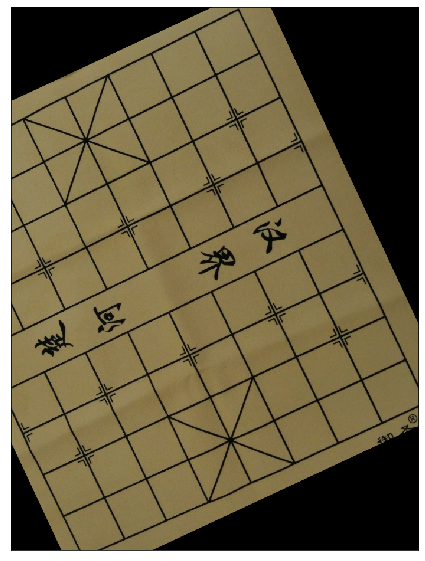

In [182]:
plt.figure(figsize=(10,10))
ax=plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(image[...,::-1])

## 特征点

In [118]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.misc
import cv2
import imreg_dft as ird

source_path = '/Users/yizuotian/pyspace/OpenCV-Python-Tutorial/001-图像配准/images/template.jpg'
target_path = '/Users/yizuotian/pyspace/OpenCV-Python-Tutorial/001-图像配准/images/IMG_20210419_085432.jpg'
target_path = '/Volumes/Elements/土方智能工厂/棋盘格/216.JPG'
src_img = cv2.imread(source_path)
tgt_img=cv2.imread(target_path)

In [131]:
import cv2
import numpy as np
def find_correspondence_points(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(
        cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(
        cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    # Find point matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.4 * n.distance:
            good.append(m)

    src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 50,confidence=0.5)
    mask = mask.ravel()

    # We select only inlier points
    pts1 = src_pts[mask == 1]
    pts2 = dst_pts[mask == 1]

    return pts1.T, pts2.T,retval,(kp1,kp2,good,mask)

In [132]:
def perspective_transform(src_pts, matrix):
    """
    对坐标点透视变换
    :param src_pts: 源坐标点 numpy [N,(x,y)]
    :param matrix: 转换矩阵 numpy [3,3]
    :return dst_pts: 目标坐标点 numpy [N,(x,y)]
    """
    num_points = src_pts.shape[0]
    constant = np.ones(shape=(num_points, 1))
    src_pts = np.concatenate([src_pts, constant], axis=1)  # [N,(x,y,1)]
    dst_pts = np.dot(matrix, src_pts.T).T  # [N,(x,y,1)]
    dst_pts[:, 0] /= dst_pts[:, 2]
    dst_pts[:, 1] /= dst_pts[:, 2]
    dst_pts = dst_pts[:, :2]  # [N,(x,y)]
    return dst_pts.astype(np.int32)

In [133]:
pts1,pts2,r,(kp1,kp2,good,mask)=find_correspondence_points(src_img,tgt_img)

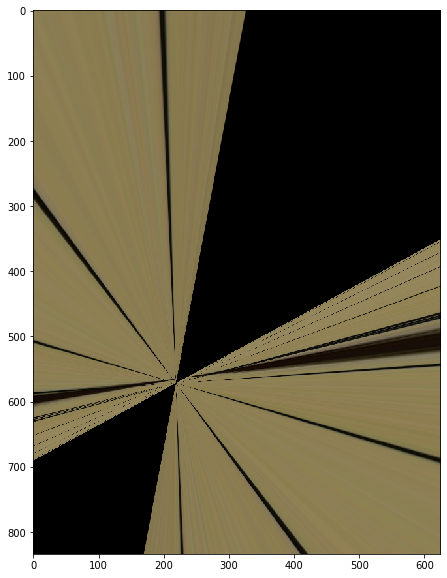

In [121]:
h,w = tgt_img.shape[:2]
image = cv2.warpPerspective(src_img,
                               M=r,
                               dsize=(w,h))
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1])

<Figure size 720x720 with 0 Axes>

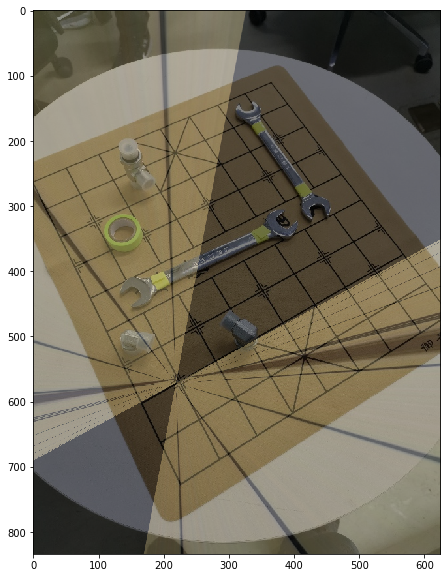

In [122]:
plt.figure(figsize=(10,10))
nim=image*0.5+tgt_img*0.5
plt.figure(figsize=(10,10))
plt.imshow(nim.astype(np.uint8)[:,:,::-1])

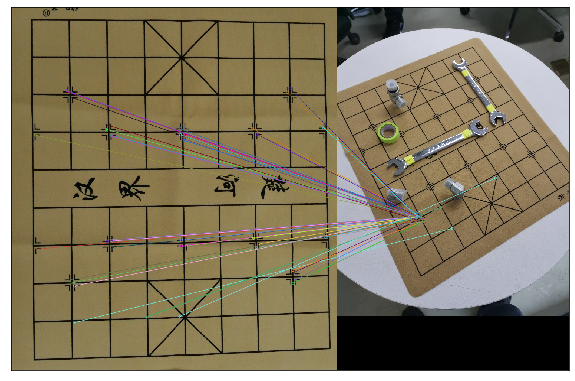

In [125]:
# 画匹配的点
img3 = cv2.drawMatches(src_img,kp1,tgt_img,kp2,np.array(good)[mask==1],None,flags=2)
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(img3[:,:,::-1])

In [124]:
kp1

[<KeyPoint 0x12d62cab0>,
 <KeyPoint 0x12d634d80>,
 <KeyPoint 0x12d6349f0>,
 <KeyPoint 0x12c7dca50>,
 <KeyPoint 0x12c7dce10>,
 <KeyPoint 0x12c7dcae0>,
 <KeyPoint 0x12c7dc930>,
 <KeyPoint 0x12c7dc9f0>,
 <KeyPoint 0x12c7dc9c0>,
 <KeyPoint 0x12c7dc990>,
 <KeyPoint 0x12c7dc8d0>,
 <KeyPoint 0x12c7dc6c0>,
 <KeyPoint 0x12c7dcb10>,
 <KeyPoint 0x12c7dc6f0>,
 <KeyPoint 0x12c7dc720>,
 <KeyPoint 0x12c7dc900>,
 <KeyPoint 0x12c7dc690>,
 <KeyPoint 0x12c7dc8a0>,
 <KeyPoint 0x12c7dc5a0>,
 <KeyPoint 0x12c7dc4e0>,
 <KeyPoint 0x12c7dc150>,
 <KeyPoint 0x12c7dc3c0>,
 <KeyPoint 0x12c7dc2a0>,
 <KeyPoint 0x12c7dc240>,
 <KeyPoint 0x12c7dc5d0>,
 <KeyPoint 0x12c7dc600>,
 <KeyPoint 0x12c7dc390>,
 <KeyPoint 0x12c7dc0f0>,
 <KeyPoint 0x12c7dc450>,
 <KeyPoint 0x12c7dc480>,
 <KeyPoint 0x12c7dc4b0>,
 <KeyPoint 0x12c7dc510>,
 <KeyPoint 0x12c7dc420>,
 <KeyPoint 0x12c7dc360>,
 <KeyPoint 0x12c7dc7b0>,
 <KeyPoint 0x12c7dc7e0>,
 <KeyPoint 0x12c7dc750>,
 <KeyPoint 0x12c7dc780>,
 <KeyPoint 0x12c7dc810>,
 <KeyPoint 0x12c7dc870>,


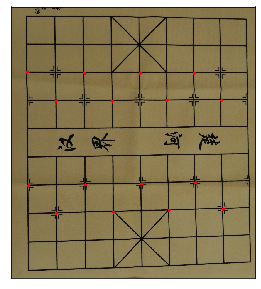

In [111]:
boxes_cord = [[147, 598, 405, 855], [662, 605, 912, 855],
                  [1160, 605, 1402, 850], [1645, 605, 1890, 850],
                  [155, 1620, 410, 1865], [670, 1610, 920, 1855],
                  [1170, 1600, 1420, 1840], [1660, 1590, 1905, 1830]]
boxes = np.array(boxes_cord,np.float32)*0.4
im=src_img.copy()
# for x1, y1, x2, y2 in boxes:
#     cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255), 5)
for x,y in boxes.reshape([-1,2]).astype(np.int32):
    cv2.circle(im,(x,y),3,(0,0,255),3)
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(im[:, :, ::-1])

In [79]:
def perspective_transform(src_pts, matrix):
    """
    对坐标点透视变换
    :param src_pts: 源坐标点 numpy [N,(x,y)]
    :param matrix: 转换矩阵 numpy [3,3]
    :return dst_pts: 目标坐标点 numpy [N,(x,y)]
    """
    num_points = src_pts.shape[0]
    constant = np.ones(shape=(num_points, 1))
    src_pts = np.concatenate([src_pts, constant], axis=1)  # [N,(x,y,1)]
    dst_pts = np.dot(matrix, src_pts.T).T  # [N,(x,y,1)]
    dst_pts[:, 0] /= dst_pts[:, 2]
    dst_pts[:, 1] /= dst_pts[:, 2]
    dst_pts = dst_pts[:, :2]  # [N,(x,y)]
    return dst_pts.astype(np.int32)

In [80]:
new_pts=perspective_transform(boxes.reshape([-1,2]),r)
new_pts

array([[493, 633],
       [493, 633],
       [493, 633],
       [492, 633],
       [491, 633],
       [505, 636],
       [502, 634],
       [495, 634],
       [492, 632],
       [481, 619],
       [383, 536],
       [495, 635],
       [495, 634],
       [494, 634],
       [494, 634],
       [494, 634]], dtype=int32)

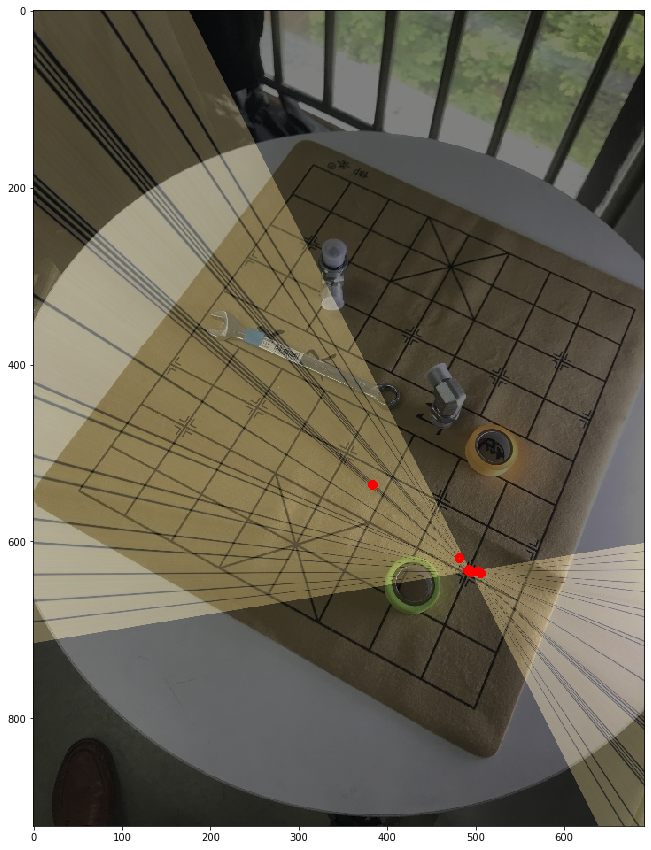

In [81]:
#nim = tgt_img.copy()
for x,y in new_pts:
    cv2.circle(nim,(x,y),3,(0,0,255),3)
plt.figure(figsize=(15,15))
plt.imshow(nim.astype(np.uint8)[:,:,::-1])

In [204]:
new_pts

array([[1353, 1284, 1367, 1300, 1382, 1316, 1397, 1331, 1048,  982, 1066,
        1000, 1084, 1020, 1102, 1038],
       [ 165,  247,  323,  403,  475,  553,  624,  702,  181,  262,  338,
         418,  491,  571,  641,  720],
       [   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1]], dtype=int32)

In [53]:
boxes.reshape([-1,2]).astype(np.int32)

array([[ 58, 239],
       [162, 342],
       [264, 242],
       [364, 342],
       [464, 242],
       [560, 340],
       [658, 242],
       [756, 340],
       [ 62, 648],
       [164, 746],
       [268, 644],
       [368, 742],
       [468, 640],
       [568, 736],
       [664, 636],
       [762, 732]], dtype=int32)

In [72]:
r

array([[ 6.46290702e-01, -4.18988022e-01,  1.45994369e+02],
       [ 2.55124920e+00, -1.65321994e+00,  5.75374304e+02],
       [ 4.43495014e-03, -2.87303844e-03,  1.00000000e+00]])

## 画匹配的点

In [15]:
source_path='/Volumes/Elements/土方智能工厂/工步防错-主阀/template.jpg'
target_path='/Volumes/Elements/土方智能工厂/工步防错-主阀/位置校准/010.jpg'

source_path='/Volumes/Elements/土方智能工厂/工步防错-主阀/位置校准/487.jpg'
target_path='/Volumes/Elements/土方智能工厂/工步防错-主阀/ggg/1010-1100/020.jpg'

src_img = cv2.imread(source_path)
tgt_img=cv2.imread(target_path)

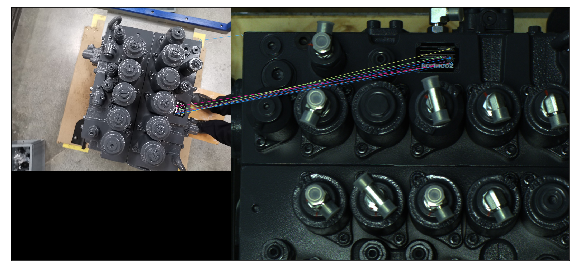

In [16]:
import cv2
import numpy as np
def find_correspondence_points(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(
        cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(
        cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    # Find point matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 
                                      ransacReprojThreshold=5,
                                      confidence=0.95)
    mask = mask.ravel()

    # We select only inlier points
    pts1 = src_pts[mask == 1]
    pts2 = dst_pts[mask == 1]

    return pts1.T, pts2.T,retval,(kp1,kp2,good,mask)

pts1,pts2,r,(kp1,kp2,good,mask)=find_correspondence_points(src_img,tgt_img)
# 画匹配的点
img3 = cv2.drawMatches(src_img,kp1,tgt_img,kp2,np.array(good)[mask==1],None,flags=2)
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(img3[:,:,::-1])

In [17]:
im_out = deal_im_valve(pts, src_img, tgt_img, colors)
plt.imshow(im_out[...,::-1])

NameError: name 'deal_im_valve' is not defined

## 主阀测试

In [145]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
def parse_file(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        ret_dic = json.load(f)
        regions = list(ret_dic['assets'].values())[0]['regions']
    pts = np.zeros(shape=(len(regions), 4, 2))  # [N,(lt,lr,br,bl),(x,y)]
    for i, region in enumerate(regions):
        for j, pt in enumerate(region['points']):
            pts[i, j, 0] = pt['x']
            pts[i, j, 1] = pt['y']

    return pts

In [9]:
xml_path='../主阀/main_valve.json'
pts=parse_file(xml_path)

In [110]:
pts.reshape(-1,2).reshape(-1,4,2).shape,pts.shape

((9, 4, 2), (9, 4, 2))

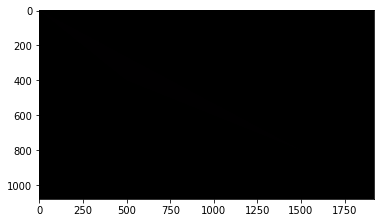

In [22]:
img = np.zeros((1080, 1920, 3), np.uint8)
triangle = np.array([[0, 0], [1500, 800], [500, 400]])
cv2.fillConvexPoly(img, triangle, random_colors(8)[1])
plt.imshow(img)
plt.show()

In [30]:
im_path = '../主阀/template.jpg'
im = cv2.imread(im_path)


In [103]:
import colorsys
import random

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = [colorsys.hsv_to_rgb(h,s,v) for h,s,v in hsv]
    # random.shuffle(colors)
    colors = np.array(colors) * 255
    return colors

In [104]:
colors=random_colors(9,False)
colors

array([[178.5,   0. ,   0. ],
       [178.5, 119. ,   0. ],
       [119. , 178.5,   0. ],
       [  0. , 178.5,   0. ],
       [  0. , 178.5, 119. ],
       [  0. , 119. , 178.5],
       [  0. ,   0. , 178.5],
       [119. ,   0. , 178.5],
       [178.5,   0. , 119. ]])

In [105]:
def draw_boxes(im, pts, colors):
    """

    :param im: [H,W,3]
    :param pts: [N,4,(x,y)]
    :param colors: [N,(B,G,R)]
    :return:
    """
    im_mask = np.zeros_like(im)

    for i, points in enumerate(pts):
        color = colors[i]
        cv2.fillConvexPoly(im_mask, points, color=color)

    im_new = (im_mask * 0.5 + im * 0.5).astype(np.uint8)

    mask = np.sum(im_mask, axis=-1)

    return np.where(mask[:,:,np.newaxis] > 0, im_new, im)

In [123]:
def deal_im_valve(src_pts, im_template, im, colors):
    """

    :param src_pts: [N,4,2]
    :param im_template: [H,W,3]
    :param im: [H,W,3]
    :param colors: [N,(B,G,R)]
    :return:
    """
    # 查找匹配点，获取透视变换矩阵
    _, _, matrix,_ = find_correspondence_points(im_template, im)
    dst_pts = perspective_transform(src_pts.reshape(-1, 2), matrix)
    dst_pts = dst_pts.reshape(-1, 4, 2)
    im_draw = draw_boxes(im, dst_pts, colors)
    return im_draw

In [106]:
img=draw_boxes(im,pts.astype(np.int32),colors)

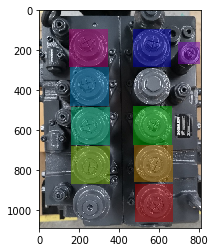

In [107]:
plt.imshow(img[...,::-1])

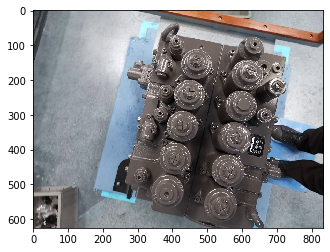

In [19]:
plt.imshow(src_img)